In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as kr
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sys

In [3]:
path='/content/drive/My Drive/Respiratory sounds/caracteristicas/'
f=pd.read_csv(path+'/Caracteristicas_50ms.csv',index_col=0)
f

,Energia m,Promedio m,RMS m,Cruces m,Energia s,Promedio s,RMS s,Cruces s,tps m,br m,sr m,sub_p1 m,sub_p2 m,sub_p3 m,sub_p4 m,sub_p5 m,tps s,br s,sr s,sub_p1 s,sub_p2 s,sub_p3 s,sub_p4 s,sub_p5 s,mfcc1 m,mfcc2 m,mfcc3 m,mfcc4 m,mfcc5 m,mfcc6 m,mfcc7 m,mfcc8 m,mfcc9 m,mfcc10 m,mfcc11 m,mfcc12 m,mfcc1 s,mfcc2 s,mfcc3 s,mfcc4 s,mfcc5 s,mfcc6 s,mfcc7 s,mfcc8 s,mfcc9 s,mfcc10 s,mfcc11 s,mfcc12 s,crackles,wheezes,diagnostic
0,2.553253,-0.031371,0.122131,4.241379,5.336925,0.038086,0.103037,4.014243,0.234337,107.838703,404.827586,0.141779,0.048672,0.021824,0.006594,0.0,0.195600,53.451173,202.103092,0.101633,0.079130,0.025170,0.007657,0.0,-6.085343,22.158143,1.005014,35.895134,-5.150398,-12.053928,8.969233,-2.396786,-5.050449,7.285175,2.397911,3.913453,2.204900,4.758190,14.315807,10.892380,12.077374,17.856538,11.062934,11.446988,13.118953,16.983218,19.034068,16.822159,0.0,0.0,1.0
1,1.382572,-0.009041,0.080063,3.967742,3.606481,0.020977,0.086114,2.669830,0.163134,139.050739,538.709677,0.102410,0.025794,0.018837,0.007761,0.0,0.187060,48.829514,168.709369,0.110785,0.040596,0.024514,0.010181,0.0,-6.818432,21.613876,1.290001,40.501303,-3.241751,-11.395707,8.418668,-2.723098,-1.041593,6.368267,-7.765651,2.312498,1.654376,5.129567,15.706070,10.991172,9.614709,14.999600,10.335534,12.210027,16.090160,13.751102,13.290188,13.146162,0.0,0.0,1.0
2,2.471295,0.011837,0.114104,4.571429,6.517090,0.035508,0.108135,3.976975,0.228398,123.879575,458.571429,0.137989,0.046458,0.023619,0.007862,0.0,0.214233,46.131068,182.281460,0.136204,0.070136,0.024704,0.008593,0.0,-6.013979,21.895815,-1.329102,35.716725,-3.902155,-13.798200,11.632101,-3.131733,-1.507739,5.900251,-1.397354,1.270730,2.110132,5.593099,14.402948,11.316585,11.483948,17.553799,10.805640,16.375225,14.719173,18.698025,20.289680,14.476539,0.0,0.0,1.0
3,1.474457,0.005497,0.075388,4.533333,5.064469,0.020985,0.095191,3.844766,0.154769,140.402113,524.666667,0.090831,0.029582,0.020167,0.007150,0.0,0.192232,49.072789,172.331721,0.110399,0.049488,0.028278,0.013074,0.0,-6.998261,21.538857,-1.471272,35.066939,-4.351941,-12.005159,8.084902,-0.147062,-2.232728,6.968595,1.292143,2.683101,2.272629,5.828861,16.288447,11.142046,13.325014,13.338420,10.654555,11.563514,14.394520,15.683233,16.241347,15.740741,0.0,0.0,1.0
4,1.335910,0.001314,0.075175,3.121212,4.302369,0.026661,0.087794,1.805003,0.153868,134.245998,526.666667,0.096499,0.022858,0.018161,0.007921,0.0,0.188998,49.114712,194.946250,0.107727,0.033622,0.026129,0.012220,0.0,-7.177118,22.832093,3.525236,40.325018,-3.211897,-6.601637,8.803662,-0.624197,-2.050225,3.894745,-2.007713,3.088214,1.855540,5.892989,14.115530,9.300235,11.869419,11.406746,11.176745,13.313913,13.604104,13.147293,12.493328,12.590977,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,2.221497,0.008684,0.116786,3.461538,4.245772,0.039566,0.092607,2.858601,0.241363,131.270679,500.769231,0.147085,0.043778,0.024397,0.011903,0.0,0.209872,50.304646,183.175474,0.099183,0.069904,0.031903,0.015353,0.0,-6.156326,24.618167,7.821267,37.086337,-11.261260,-5.294428,0.851014,0.922626,2.207867,2.637670,-9.290964,2.183869,1.959088,7.583255,11.045506,11.270316,13.672203,10.535270,10.376972,15.601220,15.057968,14.032724,14.523588,11.506020,0.0,0.0,1.0
5974,2.042143,0.004348,0.103165,3.414634,4.389522,0.060882,0.098886,2.011863,0.218102,125.821123,481.951220,0.145384,0.031951,0.021298,0.009051,0.0,0.229012,46.929830,207.414038,0.142171,0.049494,0.029329,0.011485,0.0,-6.546073,24.106909,7.487435,35.415011,-16.692820,-4.306381,3.301393,2.746189,-1.932226,1.239634,-5.687362,1.878339,1.836238,8.613981,12.083614,10.535697,11.314463,10.793716,11.034621,10.297100,12.653003,12.987131,10.871819,10.746365,0.0,0.0,1.0
5975,1.828576,0.013331,0.111553,3.083333,3.558567,0.043373,0.076432,1.681187,0.214915,122.466734,481.666667,0.147619,0.032198,0.016604

In [ ]:
np.random.seed(1)
data=f.values
X = data[:,:-3]
Y = data[:,-3:-1] #target para c y w
Y_copd= data[:,-1] #target para epoc
#scaler = StandardScaler()
scaler =MinMaxScaler((-1,1),True)#Nomaliza entre -1 y 1
X=scaler.fit_transform(X)

test_size= int(X.shape[0]*0.20) #20% para prueba
val_size = int(X.shape[0]*0.1) #10% para validacion

d = np.random.choice(np.arange(X.shape[0]) , size=X.shape[0], replace=False)
x_test = X[d[:test_size],:] 
x_val  = X[d[test_size:test_size+val_size],:]
x_train= X[d[test_size+val_size:],:] 

y_test = Y[d[:test_size]] 
y_val  = Y[d[test_size:test_size+val_size]]
y_train= Y[d[test_size+val_size:]] 

y_test_copd = Y_copd[d[:test_size]] 
y_val_copd  = Y_copd[d[test_size:test_size+val_size]]
y_train_copd= Y_copd[d[test_size+val_size:]] 

print('Dimensiones de prueba, validacion, entrenamiento: ',x_test.shape,x_val.shape,x_train.shape)

Dimensiones de prueba, validacion, entrenamiento:  (1195, 48) (597, 48) (4186, 48)


#Probar parametros

In [ ]:
global best_val_acc 
global best_val_loss 
global best_parameters
best_val_acc = 0
best_val_loss = sys.float_info.max 
best_parameters=['none' for i in range(5)]#guardare 5 paramtros
class MyCallback(kr.callbacks.Callback):
    def __init__(self,lr,tam_batch,neuronas,act):
        self.lr=lr
        self.tam_batch=tam_batch
        self.neuronas=neuronas
        self.act=act
        # best_val_acc = 0
        # best_val_loss = sys.float_info.max 
    def on_epoch_end(self, epoch, logs=None):
        global best_val_acc 
        global best_val_loss
        global best_parameters
        val_acc = logs['val_binary_accuracy']
        val_loss = logs['val_loss']

        if val_acc > best_val_acc:
            self.model.save('EPOC_no_tranfer_Best.h5')
            print('lr: '+ str(self.lr),'batch: '+ str(self.tam_batch), 
                  'num_neu: '+ str(self.neuronas),'activation: '+ str(self.act), 'epoch: '+ str(epoch))
            print('Improve from: % 2.5f to % 2.5f in acc' %(best_val_acc,val_acc))
            best_val_acc = val_acc 
            best_parameters=[str(self.neuronas),str(self.lr),str(self.act),str(self.tam_batch)]
        elif val_acc == best_val_acc:
            if val_loss < best_val_loss:
                
                self.model.save('sound_CW_Best.h5')
                print('lr: '+ str(self.lr),'batch: '+ str(self.tam_batch), 
                      'num_neu: '+ str(self.neuronas),'activation: '+ str(self.act), 'epoch: '+ str(epoch)) 
                print('Improve from: % 2.5f to % 2.5f in loss' %(best_val_loss,val_loss))  
                best_val_loss=val_loss 
                best_parameters=[str(self.neuronas),str(self.lr),str(self.act),str(self.tam_batch)]

In [ ]:
def model_g(numn=100,act='relu'):
  model = kr.Sequential()
    #capa 1
  model.add(kr.layers.Dense(numn, input_dim=48, activation=act))

  model.add(kr.layers.Dense(1, activation='sigmoid'))
  
  return model

Se exploran el numero de neuronas, el tamaño del lote, tasa de aprendizaje y función de activación para una ANN con una capa intermedia y la salida fija de 2 neuronas con activación sigmoide, todos con 200 epocas

In [ ]:
v_n=[200,100,50]#num neuronas
v_b=[64,32]#batch
v_l=[1.0e-4,1.0e-3]#lr
v_a=['relu','tanh','sigmoid']#Activacion
auc=kr.metrics.AUC(name='AUC',multi_label=True)
dir='/content/drive/My Drive/Respiratory sounds/Graficas de modelos/'#donde se guardaran las graficas

In [ ]:
for neuronas in v_n:
  for lr in v_l:
    for activacion in v_a:
      for bache in v_b: 
          t=dir+'no transfer'+'n '+ str(neuronas)+'lr '+str(lr)+'act '+str(activacion)+'b '+str(bache)+'.csv'
          csv_logger = kr.callbacks.CSVLogger(t,
                                              separator=',',
                                              append=False)
          
          model=model_g(numn=neuronas,act=activacion)

          model.compile(loss="binary_crossentropy",
                        optimizer=kr.optimizers.Adam(lr=lr), 
                        metrics=['binary_accuracy','AUC'])

          model.fit(x_train, y_train_copd,
                    batch_size = bache,
                    epochs = 200,
                    validation_data=(x_val,y_val_copd),
                    callbacks=[MyCallback(lr=lr,tam_batch=bache,neuronas=neuronas,act=activacion),csv_logger],
                    verbose=0)

lr: 0.0001 batch: 64 num_neu: 200 activation: relu epoch: 0
Improve from:  0.00000 to  0.81575 in acc
lr: 0.0001 batch: 64 num_neu: 200 activation: relu epoch: 1
Improve from:  179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.00000 to  0.44926 in loss
lr: 0.0001 batch: 64 num_neu: 200 activation: relu epoch: 2
Improve from:  0.44926 to  0.43357 in loss
lr: 0.0001 batch: 64 num_neu: 200 activation: relu epoch: 3
Improve from:  0.43357 to  0.41955 in loss
lr: 0.0001 batch: 64 num_neu: 200 activation: relu epoch: 4
Improve from:  0.41955 to  0.40502 in loss
lr: 0.0001 batch: 64 num_neu: 200 activation: relu epoch: 5
Improve from:  0.40502 to  0.39211 in loss
lr: 0.0001 batch: 64 num_neu: 200 activation: relu epoch: 6
Improve from:  

In [ ]:
print(best_parameters)

['200', '0.001', 'relu', '32']


#Mejores Modelos

In [ ]:
m1=kr.models.load_model('EPOC_no_tranfer_Best.h5')
m1.evaluate(x_train,y_train_copd),m1.evaluate(x_test,y_test_copd)

38/38 [==============================] - 0s 1ms/step - loss: 0.0848 - binary_accuracy: 0.9841 - auc: 0.9908


([0.005410300567746162, 0.9990444183349609, 0.9999761581420898],
 [0.0847829282283783, 0.9841004014015198, 0.9907804727554321])

In [ ]:
m1.save('/content/drive/My Drive/Respiratory sounds/EPOC_no_tranfer_Best.h5')#guardarlo en drive

In [ ]:
m1=kr.models.load_model('/content/drive/My Drive/Respiratory sounds/EPOC_no_tranfer_Best.h5')
m1.evaluate(x_train,y_train_copd),m1.evaluate(x_test,y_test_copd)

38/38 [==============================] - 0s 1ms/step - loss: 0.0848 - binary_accuracy: 0.9841 - auc: 0.9908


([0.005410300567746162, 0.9990444183349609, 0.9999761581420898],
 [0.0847829282283783, 0.9841004014015198, 0.9907804727554321])

In [ ]:
def MostrarResultados(file):
  fig, axs = plt.subplots(1,2,figsize=(15,5))
  history=pd.read_csv(file)

  axs[0].plot(history['epoch'].values+1,history['binary_accuracy'].values)
  axs[0].plot(history['epoch'].values+1,history['val_binary_accuracy'].values)
  axs[0].set_title('Model Accuracy')
  axs[0].set_ylabel('Binary Accuracy')
  axs[0].set_xlabel('Epoch')
  #axs[0].set_xticks(history['epoch'].values,len(history['accuracy'].values)/10)
  axs[0].legend(['train', 'val'], loc='best')
  
  # Summarize history for loss
  axs[1].plot(history['epoch'].values+1,history['loss'].values)
  axs[1].plot(history['epoch'].values+1,history['val_loss'].values)
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  #axs[1].set_xticks(history['epoch'].values,len(history['loss'].values)/10)
  axs[1].legend(['train', 'val'], loc='best')
  
  # Show the plot
  plt.show()

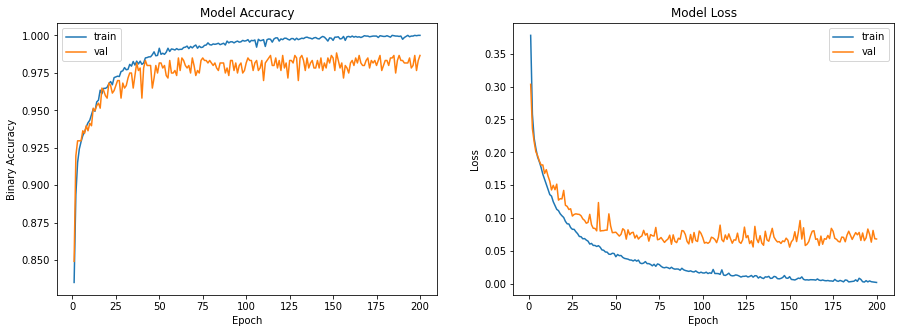

In [ ]:
MostrarResultados(dir+'no transfer'+'n '+str(200)+'lr '+str(0.001)+'act '+'relu'+'b '+str(32)+'.csv')


#Metricas


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

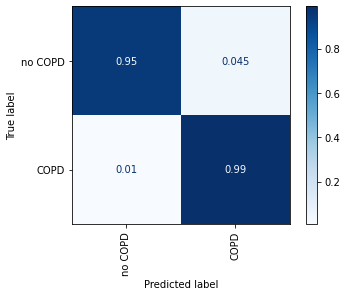

In [ ]:
fig,ax=plt.subplots()
y_pred=(m1.predict(x_test).ravel()>0.5)

cm = confusion_matrix(y_test_copd,y_pred,normalize='true')
cmp = ConfusionMatrixDisplay(cm, display_labels=('no COPD','COPD'))

cmp.plot(cmap='Blues',xticks_rotation='vertical',ax=ax)
#exp1=classification_report(y_test_copd, y_pred, target_names=('no COPD','COPD'))
#print(exp1)

In [ ]:
model2.save('/content/drive/My Drive/Respiratory sounds/COPD_transfer_Best_all.h5')